### Trabalho de Sistemas Nebulosos

Dataset: Breast Cancer Wisconsin (Diagnostic) Data Set



imports das bibliotecas utilizadas

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from copy import copy
import statistics as sts
import scipy.stats as st
from math import *

#!pip install pandas
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score

#!pip install torch===1.0.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
from torch.utils.data import TensorDataset, DataLoader

import skfuzzy as fuzz

import anfis
from membership import BellMembFunc, make_bell_mfs, GaussMembFunc, make_gauss_mfs
from experimental import *

dtype = torch.float

from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

#### Preprocessamento dos dados
- Ler dataset, retirar dados que não serão utilizados, mostrar informações
- Separar em treino (70%) e test (30%), Normalização de features (0 a 1)


In [2]:
##load no dataset
data = pd.read_csv("data.csv") 
##jogando dados não utilizaveis fora
data.pop('id').values
data.pop('Unnamed: 32').values
## separar X e y
y = data.pop('diagnosis').values
## mostrando valores
print(y.shape)
print(data.shape)
print(y[-5:])
data.head()

(569,)
(569, 30)
['M' 'M' 'M' 'M' 'B']


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:

#Codificando a anotação para numérico 1 para Maligno e 0 para benigno 
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
#Mostrando novo vetor y
print('Tamanho do vetor y: {}'.format(len(y)))
print(y[-5:])
#Pegando as features de cada amostra para treinar
X = data.values#[:,:4]
print('Tamanho do vetor X: {}'.format(X.shape))#Dividindo em 5 partes de treino e teste, ou seja, 5 folds
#Dividir entre 70% treino e 30% teste
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)
##Normalização das features
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

Tamanho do vetor y: 569
[1 1 1 1 0]
Tamanho do vetor X: (569, 30)
(398, 30)
(171, 30)


#### Divide a parte do treino em 5 folds para testar os modelos

In [4]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)
print('Tamanho do vetor das folds:')
for train, val in kf.split(X_train):
    print("  TRAIN:", train.shape, "TEST:", val.shape)

Tamanho do vetor das folds:
  TRAIN: (318,) TEST: (80,)
  TRAIN: (318,) TEST: (80,)
  TRAIN: (318,) TEST: (80,)
  TRAIN: (319,) TEST: (79,)
  TRAIN: (319,) TEST: (79,)


#### Funções e treinamento do modelo n_folds vezes

In [5]:
####X,y -> x vetor de (n_samples, features)
def our_data(X, y, batch = 1024, shuft= True):
    x_t = torch.zeros(X.shape)
    y_t = torch.zeros((len(y), 1))
    for i in range(len(X)):
            x_t[i] = torch.tensor(X[i,:])
            y_t[i] = y[i]
    dl = DataLoader(TensorDataset(x_t, y_t), batch_size=batch, shuffle=shuft)
    return dl

##Criar modelo ANFIS
def model_Daniel(X_train):
    invardefs = []
    for i in range(X_train.shape[-1]):
        invardefs.append(('x'+str(i), make_gauss_mfs(0.3,[0.7])))

    outvars = ['y']
    model = anfis.AnfisNet('model_define', invardefs, outvars)
    return model

#calc accuracy
def calc_acc(y_pred, y_actual):
    with torch.no_grad():
        tot_loss = F.mse_loss(y_pred, y_actual)
        rmse = torch.sqrt(tot_loss).item()
        perc_loss = torch.mean(100. * torch.abs((y_pred - y_actual)
                               / y_actual))
    return(tot_loss, rmse, perc_loss)


def my_train_anfis_with(model, data, optimizer, criterion,
                     epochs=500, show_plots=False):
    '''
        Train the given model using the given (x,y) data.
    '''
    errors = []  # Keep a list of these for plotting afterwards
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    print('### Training for {} epochs, training size = {} cases'.
          format(epochs, data.dataset.tensors[0].shape[0]))
    for t in range(epochs):
        # Process each mini-batch in turn:
        for x, y_actual in data:
            y_pred = model(x)
            # Compute and print loss
            loss = criterion(y_pred, y_actual)
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Epoch ending, so now fit the coefficients based on all data:
        x, y_actual = data.dataset.tensors
        with torch.no_grad():
            model.fit_coeff(x, y_actual)
        # Get the error rate for the whole batch:
        y_pred = model(x)
        mse, rmse, perc_loss = calc_error(y_pred, y_actual)
        errors.append(perc_loss)
        # Print some progress information as the net is trained:
        if epochs < 30 or t % 10 == 0:
            print('epoch {:4d}: Erro={:.5f}'
                  .format(t, mse))
    # End of training, so graph the results:
    if show_plots:
        plotErrors(errors)
        y_actual = data.dataset.tensors[1]
        y_pred = model(data.dataset.tensors[0])
        plotResults(y_actual, y_pred)

        
def my_train_model(model, data, epochs=500, show_plots=False):
    '''
        Train the given model using the given (x,y) data.
    '''
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.99)
    criterion = torch.nn.MSELoss(reduction='mean')
    my_train_anfis_with(model, data, optimizer, criterion, epochs, show_plots)

    
def my_test_model(model, data, show_plots=False):
    '''
        Do a single forward pass with x and compare with y_actual.
    '''
    x, y_actual = data.dataset.tensors
    if show_plots:
        plot_all_mfs(model, x)
    print('### Testing for {} cases'.format(x.shape[0]))
    y_pred = model(x)
    y_pred_c = [] 
    for y_p in y_pred:
        if y_p >= 0.5:
            y_pred_c.append(1)
        else:
            y_pred_c.append(0)
    y_pred = np.array(y_pred_c)
    acc = accuracy_score(y_actual, y_pred)
    pre = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    print('Accuracy={:.2f}%  Precision={:.2f}% Recall={:.2f}%'.format(acc*100,pre*100,recall*100))
    return acc, pre, recall


#define the model
epochs = 100
show_plots = True
ACC, precision, recall = [], [], []

for train, val in kf.split(X_train):
    x_train, x_val = X_train[train], X_train[val]
    y_train, y_val = Y_train[train], Y_train[val]
    
    
    #utilizar modelo de Fuzzy-Cmeans para encontrar os centros iniciais --- IDEIA
    
    model = model_Daniel(x_train)
    train_data = our_data(x_train, y_train)
    val_data = our_data(x_val, y_val)
    my_train_model(model, train_data, epochs, False)
    acc, pre, rec = my_test_model(model, val_data, False)
    ACC.append(acc)
    precision.append(pre)
    recall.append(rec)

### Training for 100 epochs, training size = 318 cases
epoch    0: Erro=0.17929


/home/jesimon/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


epoch   10: Erro=0.17334
epoch   20: Erro=0.15800
epoch   30: Erro=0.13311
epoch   40: Erro=0.10822
epoch   50: Erro=0.09023
epoch   60: Erro=0.07445
epoch   70: Erro=0.06402
epoch   80: Erro=0.05460
epoch   90: Erro=0.04881
### Testing for 80 cases
Accuracy=95.00%  Precision=96.30% Recall=89.66%
### Training for 100 epochs, training size = 318 cases
epoch    0: Erro=0.15453
epoch   10: Erro=0.14698
epoch   20: Erro=0.12897
epoch   30: Erro=0.10647
epoch   40: Erro=0.08612
epoch   50: Erro=0.07557
epoch   60: Erro=0.06736
epoch   70: Erro=0.06055
epoch   80: Erro=0.05407
epoch   90: Erro=0.05006
### Testing for 80 cases
Accuracy=92.50%  Precision=95.65% Recall=81.48%
### Training for 100 epochs, training size = 318 cases
epoch    0: Erro=0.16065
epoch   10: Erro=0.15294
epoch   20: Erro=0.13788
epoch   30: Erro=0.11717
epoch   40: Erro=0.09969
epoch   50: Erro=0.08677
epoch   60: Erro=0.07278
epoch   70: Erro=0.06331
epoch   80: Erro=0.05242
epoch   90: Erro=0.04719
### Testing for 80 

### Avaliação do Modelo
- Foram utilizadas as métricas Acuracia, precisão e revocação.
- Foram calculados também o intervalo de confiação com fator de 0.9 das métricas baseadas nas n_folds execuções, para analisar e comparar.


In [6]:
ic_acc = st.t.interval(0.9, len(ACC) - 1, loc=np.mean(ACC), scale=st.sem(ACC))
ic_recall = st.t.interval(0.9, len(recall) - 1, loc=np.mean(recall), scale=st.sem(recall))
ic_pre = st.t.interval(0.9, len(precision) - 1, loc=np.mean(precision), scale=st.sem(precision))
print('Mean Accuracy   [{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(ACC), ic_acc[0], ic_acc[1]))
print('Mean Recall     [{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(recall), ic_recall[0], ic_recall[1]))
print('Mean Precision  [{:.4f}] IC [{:.4f}, {:.4f}]\n'.format(np.mean(precision), ic_pre[0], ic_pre[1]))

Mean Accuracy   [0.9346] IC [0.9212, 0.9480]
Mean Recall     [0.8701] IC [0.8270, 0.9133]
Mean Precision  [0.9496] IC [0.9228, 0.9765]



#### Plote dos resultados para cada folds


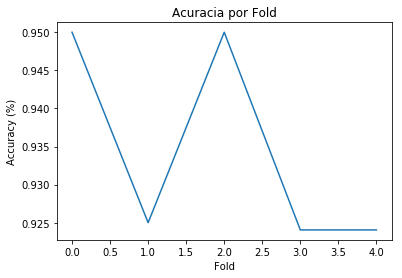

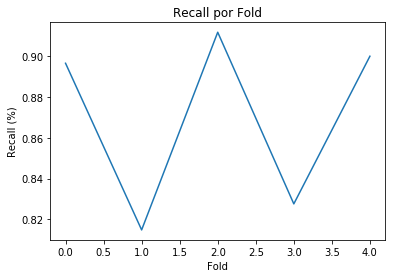

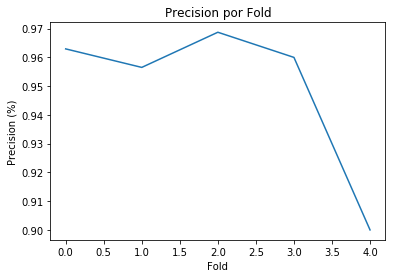

In [7]:
fig, ax = plt.subplots()
ax.plot(ACC)
ax.set(xlabel='Fold', ylabel='Accuracy (%)',
       title='Acuracia por Fold')
plt.show()

fig, ax = plt.subplots()
ax.plot(recall)
ax.set(xlabel='Fold', ylabel='Recall (%)',
       title='Recall por Fold')
plt.show()

fig, ax = plt.subplots()
ax.plot(precision)
ax.set(xlabel='Fold', ylabel='Precision (%)',
       title='Precision por Fold')
plt.show()

### Avaliação do modelo no teste
- Foram utilizadas as mesmas métricas de avaliação do treinamento
- Os valores no teste ficaram ainda maiores do que no treinamento, indicando que não houve nenhum tipo de overfitting, do mesmo modo que não está acontecendo underfitting

Os resultados mostram que o modelo tem uma acuracia muito boa, além de precisão e recall. Aprovando a qualidade do modelo.

In [9]:
test_data = our_data(X_test, Y_test)
acc, pre, rec = my_test_model(model, test_data, False)
print('Accuracy   {:.1f}%'.format(acc*100))
print('Recall     {:.1f}%'.format(rec*100))
print('Precision  {:.1f}%'.format(pre*100))

### Testing for 171 cases
Accuracy=94.74%  Precision=95.00% Recall=90.48%
Accuracy   94.7%
Recall     90.5%
Precision  95.0%
